In [1]:
import json, sys, os
import numpy as np
import pandas as pd
from enum import Enum
from scipy.optimize import root_scalar
from typing import Dict, Tuple, Union, Optional
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
print("Added to sys.path:", repo_root)
from fixedincomelib import *
print("Fixed Income Library is loaded.")

Added to sys.path: /Users/lunli/Documents/FixedIncomeLib
Fixed Income Library is loaded.


### Test Alpha Parameterization

In [2]:
### parameters
alpha = 0.04
beta = 0.6
nu = 0.5
rho = 0.5
shift = 0.04
forward = 0.04
strike = 0.042
tte = 0.5
opt_type = 'call'

In [3]:
### alpha parameterization
value_and_sensitivitities_alpha = qfEuropeanOptionSABR(
    forward,
    strike,
    tte,
    opt_type,
    alpha,
    beta,
    rho,
    nu,
    shift, 
    True)
value_and_sensitivitities_alpha

{<SimpleMetrics.PV: 'pv'>: 0.0017144993455771758,
 <SimpleMetrics.DELTA: 'delta'>: 0.35135825438301227,
 <SimpleMetrics.GAMMA: 'gamma'>: 57.154541516224455,
 <SimpleMetrics.THETA: 'theta'>: -0.002513595197606463,
 <SimpleMetrics.TTE_RISK: 'tte_risk'>: 0.002471449202956019,
 <SimpleMetrics.STRIKE_RISK: 'strike_risk'>: -0.3335776246798132,
 <SabrMetircs.DALPHA: 'dalpha'>: 0.0600807044616283,
 <SabrMetircs.DBETA: 'dbeta'>: -0.006027117354450338,
 <SabrMetircs.DRHO: 'drho'>: 9.966448940705111e-05,
 <SabrMetircs.DNU: 'dnu'>: 0.00022073403828266284,
 <SimpleMetrics.STRIKE_RISK_2: 'strike_risk_2'>: 55.487722055991284}

In [4]:
### b&r test -- first order
key = SimpleMetrics.PV
base_v = value_and_sensitivitities_alpha[key]
epsilon = 1e-6
bump_vec = [0.] * 7
for i in range(len(bump_vec)):
    bump_vec[i] += epsilon    
    bumped_v = qfEuropeanOptionSABR(
        forward + bump_vec[0],
        strike + bump_vec[1],
        tte - bump_vec[2],
        opt_type,
        alpha + bump_vec[3],
        beta + bump_vec[4],
        rho + bump_vec[5],
        nu + bump_vec[6],
        shift)
    display((bumped_v[key] - base_v) / epsilon)
    bump_vec[i] -= epsilon
# second order
bumped_up = qfEuropeanOptionSABR(forward + epsilon, strike, tte, opt_type, alpha, beta, rho, nu, shift)[SimpleMetrics.PV]
bumped_dn = qfEuropeanOptionSABR(forward - epsilon, strike, tte, opt_type, alpha, beta, rho, nu, shift)[SimpleMetrics.PV]
print(f'Gamma is {(bumped_up - 2 * base_v + bumped_dn)/epsilon/epsilon}.')
bumped_up = qfEuropeanOptionSABR(forward, strike + epsilon, tte, opt_type, alpha, beta, rho, nu, shift)[SimpleMetrics.PV]
bumped_dn = qfEuropeanOptionSABR(forward, strike - epsilon, tte, opt_type, alpha, beta, rho, nu, shift)[SimpleMetrics.PV]
print(f'Second Order Strike Risk is {(bumped_up - 2 * base_v + bumped_dn)/epsilon/epsilon}.')


0.3513737883743817

-0.33356260772596236

-0.0025135962720967964

0.06008077718319682

-0.006032340290479388

9.966444336484415e-05

0.00022073412195289244

Gamma is 57.154541516224455.
Second Order Strike Risk is 55.487722055991284.


### Test Log-Normal Parameterization

In [5]:
### parameters
ln_sigma_atm = 0.1108019639023036
beta = 0.6
nu = 0.5
rho = 0.5
shift = 0.04
forward = 0.04
strike = 0.042
tte = 0.5
opt_type = 'call'

In [6]:
### ln_sigma parameterization
value_and_sensitivitities_ln_sigma = qfEuropeanOptionSABR(
    forward,
    strike,
    tte,
    opt_type,
    ln_sigma_atm,
    beta,
    rho,
    nu,
    shift, 
    True,
    False)
value_and_sensitivitities_ln_sigma

{<SimpleMetrics.PV: 'pv'>: 0.0017144993455771758,
 <SimpleMetrics.DELTA: 'delta'>: 0.3634111266758646,
 <SimpleMetrics.GAMMA: 'gamma'>: 58.296791005663096,
 <SimpleMetrics.THETA: 'theta'>: -0.0024726496602441458,
 <SimpleMetrics.TTE_RISK: 'tte_risk'>: 0.002471449202956019,
 <SimpleMetrics.STRIKE_RISK: 'strike_risk'>: -0.3335776246798132,
 <SabrMetircs.DBETA: 'dbeta'>: 1.736885194665149e-05,
 <SabrMetircs.DRHO: 'drho'>: 0.000127020489780986,
 <SabrMetircs.DNU: 'dnu'>: 0.00014902059728490885,
 <SimpleMetrics.STRIKE_RISK_2: 'strike_risk_2'>: 55.487722055991284,
 <SabrMetircs.DLNSIGMA: 'dlnsigma'>: 0.02164347342901053}

In [7]:
### b&r test -- first order
key = SimpleMetrics.PV
base_v = value_and_sensitivitities_ln_sigma[key]
epsilon = 1e-6
bump_vec = [0.] * 7
for i in range(len(bump_vec)):
    bump_vec[i] += epsilon    
    bumped_v = qfEuropeanOptionSABR(
        forward + bump_vec[0],
        strike + bump_vec[1],
        tte - bump_vec[2],
        opt_type,
        ln_sigma_atm + bump_vec[3],
        beta + bump_vec[4],
        rho + bump_vec[5],
        nu + bump_vec[6],
        shift,
        is_alpha_parameterized=False)
    display((bumped_v[key] - base_v) / epsilon)
    bump_vec[i] -= epsilon
# second order
bumped_up = qfEuropeanOptionSABR(forward + epsilon, strike, tte, opt_type, ln_sigma_atm, beta, rho, nu, shift, is_alpha_parameterized=False)[SimpleMetrics.PV]
bumped_dn = qfEuropeanOptionSABR(forward - epsilon, strike, tte, opt_type, ln_sigma_atm, beta, rho, nu, shift, is_alpha_parameterized=False)[SimpleMetrics.PV]
print(f'Gamma is {(bumped_up - 2 * base_v + bumped_dn)/epsilon/epsilon}.')
bumped_up = qfEuropeanOptionSABR(forward, strike + epsilon, tte, opt_type, ln_sigma_atm, beta, rho, nu, shift, is_alpha_parameterized=False)[SimpleMetrics.PV]
bumped_dn = qfEuropeanOptionSABR(forward, strike - epsilon, tte, opt_type, ln_sigma_atm, beta, rho, nu, shift, is_alpha_parameterized=False)[SimpleMetrics.PV]
print(f'Second Order Strike Risk is {(bumped_up - 2 * base_v + bumped_dn)/epsilon/epsilon}.')


0.3633905002811688

-0.33356260772596236

-0.0024726507681649412

0.021643482457645025

2.9869377804470076e-05

0.00012702047746948608

0.00014902060835320086

Gamma is 58.296791005663096.
Second Order Strike Risk is 55.487722055991284.


### Test Normal Sigma Parameterization

In [8]:
# parameters
sigma_nv = 0.008
beta = 0.6
nu = 0.5
rho = 0.5
shift = 0.04
forward = 0.04
strike = 0.042
tte = 0.5
opt_type = 'call'

In [9]:
### normal sigma parameterization
value_and_sensitivitities_normal_sigma = qfEuropeanOptionSABRNormal(
    forward,
    strike,
    tte,
    opt_type,
    sigma_nv,
    beta,
    rho,
    nu,
    shift, 
    True)
value_and_sensitivitities_normal_sigma

{<SimpleMetrics.PV: 'pv'>: 0.0014823140200761371,
 <SimpleMetrics.DELTA: 'delta'>: 0.32235817431712965,
 <SimpleMetrics.GAMMA: 'gamma'>: 60.383271299757624,
 <SimpleMetrics.THETA: 'theta'>: -0.002217408804017582,
 <SimpleMetrics.TTE_RISK: 'tte_risk'>: 0.002215339012085006,
 <SimpleMetrics.STRIKE_RISK: 'strike_risk'>: -0.32250536884037545,
 <SabrMetircs.DBETA: 'dbeta'>: 1.6625983041728028e-05,
 <SabrMetircs.DRHO: 'drho'>: 0.00012486529792736815,
 <SabrMetircs.DNU: 'dnu'>: 0.00014850928345351398,
 <SimpleMetrics.STRIKE_RISK_2: 'strike_risk_2'>: 60.20512560711566,
 <SabrMetircs.DNORMALSIGMA: 'dnormalsigma'>: 0.2678942702863532}

In [10]:
### b&r test -- first order
key = SimpleMetrics.PV
base_v = value_and_sensitivitities_normal_sigma[key]
epsilon = 1e-6
bump_vec = [0.] * 7
for i in range(len(bump_vec)):
    bump_vec[i] += epsilon    
    bumped_v = qfEuropeanOptionSABRNormal(
        forward + bump_vec[0],
        strike + bump_vec[1],
        tte - bump_vec[2],
        opt_type,
        sigma_nv + bump_vec[3],
        beta + bump_vec[4],
        rho + bump_vec[5],
        nu + bump_vec[6],
        shift)
    display((bumped_v[key] - base_v) / epsilon)
    bump_vec[i] -= epsilon
# second order
bumped_up = qfEuropeanOptionSABRNormal(forward + epsilon, strike, tte, opt_type, sigma_nv, beta, rho, nu, shift)[SimpleMetrics.PV]
bumped_dn = qfEuropeanOptionSABRNormal(forward - epsilon, strike, tte, opt_type, sigma_nv, beta, rho, nu, shift)[SimpleMetrics.PV]
print(f'Gamma is {(bumped_up - 2 * base_v + bumped_dn)/epsilon/epsilon}.')
bumped_up = qfEuropeanOptionSABRNormal(forward, strike + epsilon, tte, opt_type, sigma_nv, beta, rho, nu, shift)[SimpleMetrics.PV]
bumped_dn = qfEuropeanOptionSABRNormal(forward, strike - epsilon, tte, opt_type, sigma_nv, beta, rho, nu, shift)[SimpleMetrics.PV]
print(f'Second Order Strike Risk is {(bumped_up - 2 * base_v + bumped_dn)/epsilon/epsilon}.')


0.3223482147873824

-0.3224855315286934

-0.0022174097696892048

0.26789617993405734

2.6682302201042063e-05

0.00012486529518684897

0.00014850930901699755

Gamma is 60.383271299757624.
Second Order Strike Risk is 60.20512560711566.


In [11]:
### b&r test -- first order
key = SimpleMetrics.PV
base_v = value_and_sensitivitities_normal_sigma[key]
epsilon = 1e-6 
bumped_up = qfEuropeanOptionSABRNormal(
    forward,
    strike,
    tte,
    opt_type,
    sigma_nv,
    beta + epsilon/2.,
    rho,
    nu,
    shift)
bumped_dn = qfEuropeanOptionSABRNormal(
    forward,
    strike,
    tte,
    opt_type,
    sigma_nv,
    beta - epsilon/2.,
    rho,
    nu,
    shift)
(bumped_up[SimpleMetrics.PV] - bumped_dn[SimpleMetrics.PV])/epsilon

2.668231607882987e-05

### Test SABR CDF and PDF

In [17]:
# parameters
sigma_nv = 0.008
beta = 0.6
nu = 0.5
rho = 0.5
shift = 0.04
forward = 0.04
tte = 0.5

In [18]:
# grid spec
x_min = - shift + 1e-4
x_max = 0.1
num_pts = 1000

In [19]:
### sapmling
df_res = qfEuropeanOptionSABRPdfAndCdf(
    forward,
    tte,
    sigma_nv,
    beta,
    rho,
    nu,
    x_min,
    x_max,
    num_pts,
    shift,
    False,
    False)

/Users/lunli/Documents/FixedIncomeLib/fixedincomelib/apis/analytics.py:303: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.ShiftedForwar = xs_shifted


/Users/lunli/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lunli/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lunli/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lunli/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

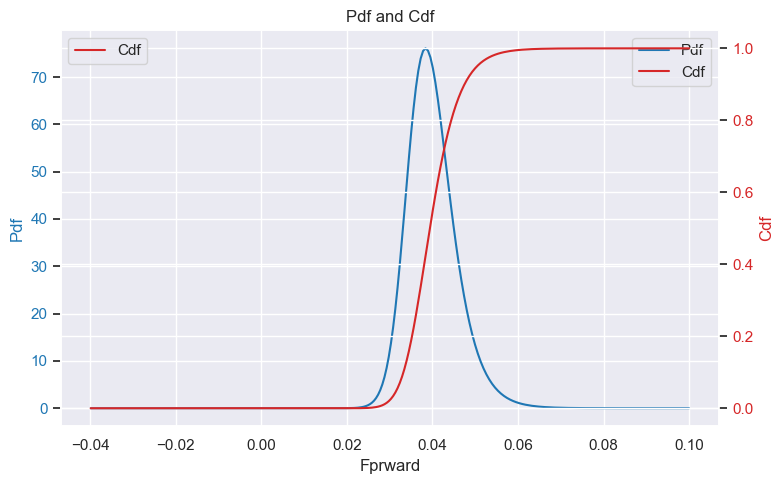

In [22]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# PDF on left y-axis
sns.lineplot(data=df_res, x="Forward", y="Pdf", ax=ax1, color="tab:blue", label="Pdf")
ax1.set_ylabel("Pdf", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
# CDF on right y-axis
ax2 = ax1.twinx()
sns.lineplot(data=df_res, x="Forward", y="Cdf", ax=ax2, color="tab:red", label="Cdf")
ax2.set_ylabel("Cdf", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
# Shared x-axis label
ax1.set_xlabel("Fprward")
# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
plt.title("Pdf and Cdf")
plt.tight_layout()
plt.show()